In [1]:
import matplotlib.pyplot as plt
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import backend as K
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics 
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline           

Using TensorFlow backend.


In [2]:
# create the base pre-trained model
# build the VGG16 network
base_model = applications.mobilenet_v2.MobileNetV2(weights='imagenet', include_top=False, 
                                input_shape=(150,150,3))
print('Model loaded.')
base_model.summary()

/home/mlab/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '
W0215 19:24:31.098202 140603817547584 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0215 19:24:31.110082 140603817547584 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0215 19:24:31.113818 140603817547584 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random

9412608/9406464 [==============================] - 0s 0us/step
Model loaded.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
________________________________

In [3]:
# this is the model we will train
model =Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8192256   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 10,450,497
Trainable params: 10,416,385
Non-trainable params: 34,112
_________________________________________________________________


In [4]:
print('Number of trainable weights before freezing: ', len(model.trainable_weights))
## to freesze all convolutional layers in pretrained network method 1
# base_model.trainable=False

Number of trainable weights before freezing:  160


In [5]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall
# def precision_m(y_true, ypred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
#     precision = true_positives/(predicted_positives+K.epsilon())
#     return precision 

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional pretrained layers method 2
for layer in base_model.layers:
    layer.trainable = False
print('After freezing: ', len(model.trainable_weights))
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'], loss='binary_crossentropy')


W0215 19:24:39.941915 140603817547584 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0215 19:24:39.950364 140603817547584 deprecation.py:323] From /home/mlab/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


After freezing:  4


In [6]:
train_data_dir = '/home/mlab/Documents/brats_hl_data/train'
validation_data_dir = '/home/mlab/Documents/brats_hl_data/val'
# 44938
# 5616
nb_train_samples = 44938
nb_validation_samples = 5616
epochs = 8
batch_size = 32
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 44938 images belonging to 2 classes.
Found 5616 images belonging to 2 classes.


In [7]:
true_classes = train_generator.classes
print(true_classes)
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

[0 0 0 ... 1 1 1]
['high', 'low']


In [8]:
# train the model on the new data for a few epochs
history =model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples//batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples//batch_size)

Epoch 1/8
351/351 [==============================] - 634s 2s/step - loss: 0.5163 - acc: 0.7336 - val_loss: 0.4522 - val_acc: 0.7718
Epoch 2/8
351/351 [==============================] - 627s 2s/step - loss: 0.4043 - acc: 0.8047 - val_loss: 0.4054 - val_acc: 0.7996
Epoch 3/8
351/351 [==============================] - 547s 2s/step - loss: 0.3585 - acc: 0.8304 - val_loss: 0.4073 - val_acc: 0.7972
Epoch 4/8
351/351 [==============================] - 540s 2s/step - loss: 0.3214 - acc: 0.8505 - val_loss: 0.3625 - val_acc: 0.8245
Epoch 5/8
351/351 [==============================] - 537s 2s/step - loss: 0.2977 - acc: 0.8642 - val_loss: 0.3480 - val_acc: 0.8344
Epoch 6/8
351/351 [==============================] - 617s 2s/step - loss: 0.2757 - acc: 0.8778 - val_loss: 0.3614 - val_acc: 0.8273
Epoch 7/8
351/351 [==============================] - 629s 2s/step - loss: 0.2582 - acc: 0.8864 - val_loss: 0.3199 - val_acc: 0.8562
Epoch 8/8
351/351 [==============================] - 627s 2s/step - loss: 0.

In [9]:
true_classes_1 = validation_generator.classes
print(true_classes)
class_labels_1 = list(validation_generator.class_indices.keys())
print(class_labels_1)

[0 0 0 ... 1 1 1]
['high', 'low']


In [10]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


In [11]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = (Y_pred<0.475).astype(np.int)

# print('Confusion Matrix')
# print(confusion_matrix(true_classes_1, y_pred))
# print('Classification Report')
# print(classification_report(validation_generator.classes, y_pred, 
#                             target_names=class_labels_1))


In [12]:
# print(validation_generator.classes)

In [13]:
confusion_matrix = metrics.confusion_matrix(true_classes_1,y_pred)
print(confusion_matrix)

[[1447 1328]
 [1553 1288]]


In [14]:
report= sklearn.metrics.classification_report(true_classes_1, y_pred, 
                                              target_names = class_labels_1)
print(report)

              precision    recall  f1-score   support

        high       0.48      0.52      0.50      2775
         low       0.49      0.45      0.47      2841

   micro avg       0.49      0.49      0.49      5616
   macro avg       0.49      0.49      0.49      5616
weighted avg       0.49      0.49      0.49      5616



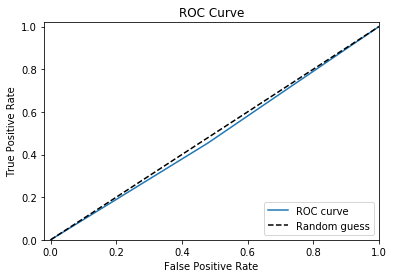

In [15]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes, y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [16]:
roc_auc_score(validation_generator.classes, y_pred)

0.48740146693684183

In [17]:
batchX, batchy = train_generator.next()
_, accuracy = model.evaluate(batchX, batchy)
print('Accuracy training: %.2f' % (accuracy*100))
batchXv, batchyv = validation_generator.next()
_, accuracy = model.evaluate(batchXv, batchyv)
print('Accuracy val: %.2f' % (accuracy*100))

128/128 [==============================] - 2s 13ms/step
Accuracy training: 92.19
128/128 [==============================] - 2s 12ms/step
Accuracy val: 86.72


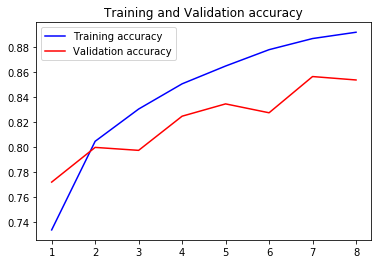

In [18]:
#plot the train and val curve
#get the details from the history object
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#train and validation accuracy
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

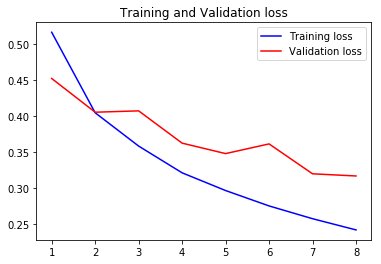

In [19]:
#train and validation loss
plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
test_generator = test_datagen.flow_from_directory('/home/mlab/Documents/brats_hl_data/test', 
                                      class_mode='binary', 
                                      batch_size=batch_size, 
                                      target_size=(150,150))
scores = model.evaluate_generator(test_generator, steps=nb_validation_samples//batch_size)

Found 5619 images belonging to 2 classes.


In [21]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 84.88%


In [22]:
#Confution Matrix and Classification Report
# Y_pred = model.predict_generator(val_generator, 5616 // batch_size)
nb_test_samples=5619
Y_pred1 = model.predict_generator(test_generator,nb_test_samples//batch_size+1)
# y_pred = np.argmax(Y_pred,axis=1)

In [23]:
true_classes_2 = test_generator.classes
print(true_classes_2)
class_labels_2 = list(test_generator.class_indices.keys())
print(class_labels_2)

[0 0 0 ... 1 1 1]
['high', 'low']


In [24]:
# y_pred1 = (Y_pred1<0.5).astype(np.int)
y_pred1 = (Y_pred1 < 0.475).astype(np.int)
# print(y_pred)
# print('Confusion Matrix')
# print(confusion_matrix(true_classes_2, y_pred1))
# print('Classification Report')
# print(classification_report(true_classes_2, y_pred1, target_names=class_labels_2))


In [25]:
confusion_matrix1 = metrics.confusion_matrix(true_classes_2,y_pred1)
print(confusion_matrix1)

[[1507 1269]
 [1557 1286]]


In [26]:
report1= sklearn.metrics.classification_report(true_classes_2, y_pred1, 
                                               target_names = class_labels_2)
print(report1)

              precision    recall  f1-score   support

        high       0.49      0.54      0.52      2776
         low       0.50      0.45      0.48      2843

   micro avg       0.50      0.50      0.50      5619
   macro avg       0.50      0.50      0.50      5619
weighted avg       0.50      0.50      0.50      5619



In [27]:
print(" Loss: ", scores[0],"\n","Accuracy: ", scores[1])

 Loss:  0.327809503951738 
 Accuracy:  0.8488372093023255
